### Автор: Омаров Руслан
### Тема: Система для мониторинга свободных аудиторий в рамках составленного расписания

### Постановка задачи

#### Предметная область
Расписание занятий. В учебном заведении проводятся занятия для разных форм
обучения: дневная, вечерняя. Кроме того, по некоторым дням для студентов проводятся
факультативы (практические занятия), которые длятся дольше, чем обычные занятия. Для
удобства планирования и учета расписания, планирование производится не по времени, а
по парам. Однако при этом, для разных форм обучения и факультативов, разным номерам
пар, соответствует разное время начала и окончания (согласно временной сетке).
#### Проблема
Согласно базовым ограничениям, в одной аудитории может проходить одно занятие.
Для того чтобы вычислить список доступных аудиторий, необходимо учесть доступность
аудитории не по номеру пары, а по времени.Информационная система, предназначенная для планирования расписания, для удобства диспетчера (пользователя) должна предоставлять список доступных (свободных) аудиторий на выбранную пару. При большом объеме данных, система слишком долго вычисляет список свободных аудиторий.
#### Задача
Проведите анализ предметной области и предложите структуру данных, которая
способна сохранить данные о занятости таким образом, что время, потраченное на поиск
свободных аудиторий, будет минимальным. При этом учтите, что количество запросов
данных значительно превышает операции вставки данных (создание новых занятий),
удаления данных (отмена занятий) или изменения данных (перенос занятия).
Синтезируйте данные для спроектированной структуры данных. Постройте проверочные
запросы, доказывающие применимость спроектированной схемы и скорость работы
запросов.

### Анализ технологий
На сегодняшний день существует множество способов организации и хранения данных. Одним из наиболее популярных является способ представления данных в виде реляционных таблиц. В данном решении был выбран именно этот способ, но сначала обсудим другие возможные варианты. 

1. Базы данных для временных рядов.
Этот вид баз данных создан таким образом, чтобы максимально эффективно оперировать с временными рядами. Расписание занятий также может быть представлено в виде временного ряда (например, для каждой аудитории строится временной ряд, где точка со значением 1 будет означать, что аудитории занята, а со значением 0 - свободна; тогда для каждой аудитории временной ряд будет выглядеть как кусочно-постоянная функция, с которой, в принципе, понятно как работать). Однако большинство таких систем оптимизированы под операции добавления и чтения из-за физической природы временных рядов. Это может вызывать трудности в случаях, когда будет необходимо часто изменять или удалять записи.

2. Документориентированные базы данных. 
Эти базы данных достаточно популярны среди нереляционных баз данных, но здесь возникает вопрос в эффективном представлении информации внутри базы: либо на каждую аудиторию нужно заводить отдельный документ, либо проделывать всё то же самое для групп и преподавателей. Поскольку записи тогда в любом случае будут иметь строгий формат (каждая запись будет нести информацию о паре и иметь фиксированное кол-во атрибутов), то это будет очень сильно напоминать реляционные таблицы.

3. Графовые базы данных.
Этот вид баз, на мой взгляд, является очень специфичным и не совсем подходит в данной задаче, поскольку очень трудно будет интерпретировать вершины графа, ребра и направления этих ребер внутри графа. 

Таким образом, после проведенного анализа выбор пал на реляционные базы данных. Они имеют ряд преимуществ:
1. Широко распространены.
2. Есть большой выбор различных реализаций, в том числе бесплатных.
3. Почти не требуют дополнительных компонент.
4. В данной задаче информация удобным образом представима в виде реляционных таблиц.


Для мониторинга и внутреннего представления данных будем использовать SQL СУБД PostgreSQL. Внутри будут следующие таблицы:
1. Преподаватели (ключ, имя).
2. Группы (ключ, номер, необходимые предметы и кол-во занятий).
3. Пары (ключ, преподаватель, аудитория, группа, начало пары, конец пары).

Основной будет как раз таблица пар. По ней и будем определять с помощью SQL-запросов свободные аудитории. 

Для проверки работоспособности системы будет использован автоматически сгенерированный с помощью [Google OR-Tools](https://developers.google.com/optimization) набор данных.
Для автоматической генерации расписания с помощью упомянутого инструмента, правда, необходимо одно предположение: преподаватель закрепляется за аудиторией.

### Стек технологий
Для построения прототипа системы были выбраны следующие инструменты:
1. СУБД PostgreSQL - система с открытым исходным кодом, которая широко распространена.
2. Google OR-Tools - инструмент для автоматизированной генерации расписания с предварительным заданием плана занятий.
3. Python 3.6 (pandas, seaborn) и Jupyter Notebook - для быстрого и наглядного проектирования системы.

In [216]:
import random as rn
import psycopg2
from configparser import ConfigParser
import time
import pandas as pd

In [217]:
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [218]:
 def connect(statement='SELECT version()'):
    """ Connect to the PostgreSQL database server """
    assert isinstance(statement, str)
    conn = None
    try:
        # read connection parameters
        params = config()
 
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
      
        # create a cursor
        cur = conn.cursor()
        
        # execute a statement
        print('PostgreSQL database version:')
        cur.execute(statement)
 
        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
       # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

def insert_list(ls):
    """ insert multiple rows  """
    sql = "INSERT INTO timetable (teacher_id, name_of_subj, group_id, start, end_time) VALUES(%s, %s, %s, %s, %s)"
    conn = None
    try:
        # read database configuration
        params = config()
        # connect to the PostgreSQL database
        conn = psycopg2.connect(**params)
        # create a new cursor
        cur = conn.cursor()
        # execute the INSERT statement
        cur.executemany(sql, ls)
        # commit the changes to the database
        conn.commit()
        # close communication with the database
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

In [284]:
def create_tables(commands=[]):
    """ create tables in the PostgreSQL database"""
    assert isinstance(commands, list or tuple)
    commands = (
        """ CREATE TABLE teachers (
                teacher_id INTEGER PRIMARY KEY,
                teacher_name VARCHAR(255) NOT NULL,
                teachers_comp VARCHAR(255) NOT NULL
                )
        """,
        """
        CREATE TABLE groups (
                group_id INTEGER PRIMARY KEY,
                groups_plan VARCHAR(255) NOT NULL
        )
        """,
        """
        CREATE TABLE timetable (
            id_of_pair INTEGER PRIMARY KEY,
            teacher_id INT NOT NULL,
            name_of_subj VARCHAR(255) NOT NULL, 
            group_id INT NOT NULL,
            start INT NOT NULL,
            end_time INT NOT NULL,
            FOREIGN KEY (teacher_id)
                REFERENCES teachers (teacher_id)
                ON UPDATE CASCADE ON DELETE CASCADE,
            FOREIGN KEY (group_id)
                REFERENCES groups (group_id)
                ON UPDATE CASCADE ON DELETE CASCADE
        )
        """,
    )
    conn = None
    try:
        # read the connection parameters
        params = config()
        # connect to the PostgreSQL server
        conn = psycopg2.connect(**params)
        cur = conn.cursor()
        # create table one by one
        for command in commands:
            cur.execute(command)
        # close communication with the PostgreSQL database server
        cur.close()
        # commit the changes
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

In [285]:
create_tables()

### Генерация данных
Данные для искусственного расписания будут генерироваться следующим образом:
1. Для начала необходимо определить 3 параметра: количество групп, количество преподавателей (оно же и кол-во аудиторий по предположению, количество учебных предметов). 
2. Далее нужно определить области компетенции преподавателей: какой преподаватель какие учебные предметы может вести (в моем случае от 3 до 5, всего предметов будет 6).
3. Затем генерируем для каждой группы кол-во занятий в этот день (в рамках разумного от 3 до 6). Каждое занятие - это какая-то пара по учебному предмету. Сначала вычисляется кол-во занятий, затем набор предметов, который будет проводиться в этот день, затем время каждого занятия (1 пара или полторы для практикумов/семинаров). Кроме того, для каждого занятия будет равновероятно выбираться преподаватель из тех, кто может вести данное занятие (соотвественно, и аудитория). 
4. Далее, данные в специальном виде (про него ниже) отправляются в инструмент ortools для генерации расписания.
5. Полученное расписание вносится в целевую таблицу в базе данных и уже с ней производятся все манипуляции: запросы аудиторий, изменение/добавление/удаление пар.

#### Про формат данных для генерации расписания
Для автоматической генерации расписания с помощью пакета ortools нужно данные предоставить в особом виде. Для начала немного обозначений:
1. Пусть преподаватель с закрепленной аудиторией - машина.
2. Группа - это определенная работа.
Данные надо предоставить в следующем виде: это должен быть список списков длины равной количеству групп. Каждый внутренний список состоит из кортежей (id машины, время выполнения работы на этой машине). Для этого, в частности, и нужно было привязать преподавателей к аудитории. 

Каждый такой маленький список можно интерпретировать как расписание для одной группы: у группы i должно быть занятие по мат.анализу (здесь мы выбираем случайного преподавателя (соответственно, номер машины), который способен провести это занятие) продолжительностью полторы пары, и т.д.

In [244]:
N_TEACHERS = 20
N_GROUPS = 10
N_SUBJECTS = 6
MAX_NUM_OF_PAIRS = 6
MIN_NUM_OF_PAIRS = 3
MAX_NUM_OF_COURSES = 5
MIN_NUM_OF_COURSES = 3

courses = ["Мат.анализ", "Дискретная математика", "Программирование", "Алгебра", "Геометрия", "Теория вероятностей"]

def get_data():
    
    # получаем набор компетенций преподавателей
    teachers_comp = {}
    for i in range(N_TEACHERS):
        n_comp = rn.randint(MIN_NUM_OF_COURSES, MAX_NUM_OF_COURSES)
#         teachers_comp[i + 1] = "|".join(rn.sample(courses, n_comp))
        teachers_comp[i + 1] = rn.sample(courses, n_comp)
        
    # получим обратный словарь ({предмет: [номера преподавателей]}) для генерации вышеуказанных списков работ
    sub_d = {key: [] for key in courses}
    for item in teachers_comp:
        for sub in teachers_comp[item]:
            sub_d[sub].append(item)
    
    # получаем набор занятий для групп в формате (предмет, время занятия)
    groups_pairs = {}
    for i in range(N_GROUPS):
        n_pairs = rn.randint(MIN_NUM_OF_PAIRS, MAX_NUM_OF_PAIRS)
        ls = []
        for j in range(n_pairs):
            ls.append((rn.sample(courses, 1)[0], rn.sample([1, 2], 1)[0]))
        groups_pairs[i + 1] = ls
#         groups_pairs[i + 1] = "|".join([" ".join(map(str, item)) for item in ls])

    data_for_ortools = []
    timetable = {}
    for item in groups_pairs:
        ls = []
        ls_time = []
        for subj, time in groups_pairs[item]:
            id_teacher = rn.sample(sub_d[subj], 1)[0]
            ls_time.append((subj, id_teacher, time))
            ls.append((id_teacher, time))
        timetable[item] = ls_time
        data_for_ortools.append(ls)
        
    return data_for_ortools, timetable
    
    

In [245]:
data_for_ortools, lessons = get_data()

In [246]:
data_for_ortools

[[(14, 1), (8, 2), (8, 1), (7, 1), (6, 1)],
 [(3, 2), (15, 2), (17, 1)],
 [(3, 2), (15, 2), (9, 1), (12, 2)],
 [(17, 1), (13, 2), (4, 2), (4, 2), (18, 2)],
 [(2, 2), (17, 2), (7, 2), (3, 2), (17, 1)],
 [(8, 1), (6, 2), (2, 1)],
 [(8, 1), (1, 2), (5, 1), (20, 1), (16, 2), (6, 2)],
 [(11, 1), (1, 2), (16, 2), (9, 2)],
 [(20, 2), (12, 2), (14, 2), (8, 2)],
 [(11, 2), (10, 2), (18, 2)]]

In [247]:
lessons

{1: [('Мат.анализ', 14, 1),
  ('Теория вероятностей', 8, 2),
  ('Теория вероятностей', 8, 1),
  ('Мат.анализ', 7, 1),
  ('Алгебра', 6, 1)],
 2: [('Мат.анализ', 3, 2),
  ('Мат.анализ', 15, 2),
  ('Теория вероятностей', 17, 1)],
 3: [('Мат.анализ', 3, 2),
  ('Геометрия', 15, 2),
  ('Программирование', 9, 1),
  ('Теория вероятностей', 12, 2)],
 4: [('Дискретная математика', 17, 1),
  ('Геометрия', 13, 2),
  ('Программирование', 4, 2),
  ('Геометрия', 4, 2),
  ('Алгебра', 18, 2)],
 5: [('Программирование', 2, 2),
  ('Теория вероятностей', 17, 2),
  ('Программирование', 7, 2),
  ('Дискретная математика', 3, 2),
  ('Теория вероятностей', 17, 1)],
 6: [('Геометрия', 8, 1), ('Алгебра', 6, 2), ('Теория вероятностей', 2, 1)],
 7: [('Алгебра', 8, 1),
  ('Дискретная математика', 1, 2),
  ('Дискретная математика', 5, 1),
  ('Дискретная математика', 20, 1),
  ('Алгебра', 16, 2),
  ('Алгебра', 6, 2)],
 8: [('Геометрия', 11, 1),
  ('Алгебра', 1, 2),
  ('Алгебра', 16, 2),
  ('Мат.анализ', 9, 2)],
 9: [

Как видно из вывода выше каждая запись в словаре представляет собой набор занятий для определенной группы, где каждое занятие представляется в виде кортежа: название предмета; id преподавателя, которые проводит данное занятие; продолжительность занятия.

### Генерация расписания

In [248]:
%%time
from __future__ import print_function

import collections

# Import Python wrapper for or-tools CP-SAT solver.
from ortools.sat.python import cp_model


def MinimalJobshopSat(jobs_data=None):
    """Minimal jobshop problem."""
    # Create the model.
    model = cp_model.CpModel()

    machines_count = 1 + max(task[0] for job in jobs_data for task in job)
    all_machines = range(machines_count)

    # Computes horizon dynamically as the sum of all durations.
    horizon = sum(task[1] for job in jobs_data for task in job)

    # Named tuple to store information about created variables.
    task_type = collections.namedtuple('task_type', 'start end interval')
    # Named tuple to manipulate solution information.
    assigned_task_type = collections.namedtuple('assigned_task_type',
                                                'start job index duration')

    # Creates job intervals and add to the corresponding machine lists.
    all_tasks = {}
    machine_to_intervals = collections.defaultdict(list)

    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            duration = task[1]
            suffix = '_%i_%i' % (job_id, task_id)
            start_var = model.NewIntVar(0, horizon, 'start' + suffix)
            end_var = model.NewIntVar(0, horizon, 'end' + suffix)
            interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                                'interval' + suffix)
            all_tasks[job_id, task_id] = task_type(
                start=start_var, end=end_var, interval=interval_var)
            machine_to_intervals[machine].append(interval_var)

    # Create and add disjunctive constraints.
    for machine in all_machines:
        model.AddNoOverlap(machine_to_intervals[machine])

    # Precedences inside a job.
    for job_id, job in enumerate(jobs_data):
        for task_id in range(len(job) - 1):
            model.Add(all_tasks[job_id, task_id +
                                1].start >= all_tasks[job_id, task_id].end)

    # Makespan objective.
    obj_var = model.NewIntVar(0, horizon, 'makespan')
    model.AddMaxEquality(obj_var, [
        all_tasks[job_id, len(job) - 1].end
        for job_id, job in enumerate(jobs_data)
    ])
    model.Minimize(obj_var)

    # Solve model.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL:
        # Create one list of assigned tasks per machine.
        assigned_jobs = collections.defaultdict(list)
        for job_id, job in enumerate(jobs_data):
            for task_id, task in enumerate(job):
                machine = task[0]
                assigned_jobs[machine].append(
                    assigned_task_type(
                        start=solver.Value(all_tasks[job_id, task_id].start),
                        job=job_id,
                        index=task_id,
                        duration=task[1]))

        # Create per machine output lines.
        ans = {key:[] for key in range(machines_count)}
        for machine in all_machines:
            # Sort by starting time.
            assigned_jobs[machine].sort()

            for assigned_task in assigned_jobs[machine]:
                id_group = assigned_task.job
                ind_of_pair = assigned_task.index

                start = assigned_task.start
                duration = assigned_task.duration
                
                ans[machine].append((id_group, ind_of_pair, start, start + duration))

        return ans

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 28.1 µs


In [249]:
%%time
res_timetable = MinimalJobshopSat(data_for_ortools)

CPU times: user 24.3 ms, sys: 3 µs, total: 24.3 ms
Wall time: 23 ms


In [250]:
res_timetable

{0: [],
 1: [(7, 1, 1, 3), (6, 1, 3, 5)],
 2: [(4, 0, 0, 2), (5, 2, 3, 4)],
 3: [(1, 0, 0, 2), (2, 0, 2, 4), (4, 3, 6, 8)],
 4: [(3, 2, 3, 5), (3, 3, 5, 7)],
 5: [(6, 2, 5, 6)],
 6: [(5, 1, 1, 3), (0, 4, 7, 8), (6, 5, 9, 11)],
 7: [(4, 2, 4, 6), (0, 3, 6, 7)],
 8: [(5, 0, 0, 1), (6, 0, 1, 2), (0, 1, 2, 4), (0, 2, 4, 5), (8, 3, 6, 8)],
 9: [(2, 2, 6, 7), (7, 3, 7, 9)],
 10: [(9, 1, 3, 5)],
 11: [(7, 0, 0, 1), (9, 0, 1, 3)],
 12: [(8, 1, 2, 4), (2, 3, 7, 9)],
 13: [(3, 1, 1, 3)],
 14: [(0, 0, 0, 1), (8, 2, 4, 6)],
 15: [(1, 1, 2, 4), (2, 1, 4, 6)],
 16: [(7, 2, 3, 5), (6, 4, 7, 9)],
 17: [(3, 0, 0, 1), (4, 1, 2, 4), (1, 2, 4, 5), (4, 4, 8, 9)],
 18: [(9, 2, 5, 7), (3, 4, 7, 9)],
 19: [],
 20: [(8, 0, 0, 2), (6, 3, 6, 7)]}

Здесь нужно преобразовать полученное расписание в читаемый вид, в том числе для занесения в таблицу базы данных. Каждый кортеж состоит из 4 чисел: id группы, номер пары для этой группы в словаре lessons, время начала занятия, время окончания занятия.

In [251]:
def format_data(d, timetable):
    ans = []
    for item in d:
        for group_id, id_of_pair, start, end in d[item]:
            ans.append((item, timetable[group_id + 1][id_of_pair][0], group_id + 1, start, end))
    return ans

In [252]:
timetable_for_db = format_data(res_timetable, lessons)

In [253]:
timetable_for_db

[(1, 'Алгебра', 8, 1, 3),
 (1, 'Дискретная математика', 7, 3, 5),
 (2, 'Программирование', 5, 0, 2),
 (2, 'Теория вероятностей', 6, 3, 4),
 (3, 'Мат.анализ', 2, 0, 2),
 (3, 'Мат.анализ', 3, 2, 4),
 (3, 'Дискретная математика', 5, 6, 8),
 (4, 'Программирование', 4, 3, 5),
 (4, 'Геометрия', 4, 5, 7),
 (5, 'Дискретная математика', 7, 5, 6),
 (6, 'Алгебра', 6, 1, 3),
 (6, 'Алгебра', 1, 7, 8),
 (6, 'Алгебра', 7, 9, 11),
 (7, 'Программирование', 5, 4, 6),
 (7, 'Мат.анализ', 1, 6, 7),
 (8, 'Геометрия', 6, 0, 1),
 (8, 'Алгебра', 7, 1, 2),
 (8, 'Теория вероятностей', 1, 2, 4),
 (8, 'Теория вероятностей', 1, 4, 5),
 (8, 'Теория вероятностей', 9, 6, 8),
 (9, 'Программирование', 3, 6, 7),
 (9, 'Мат.анализ', 8, 7, 9),
 (10, 'Программирование', 10, 3, 5),
 (11, 'Геометрия', 8, 0, 1),
 (11, 'Мат.анализ', 10, 1, 3),
 (12, 'Алгебра', 9, 2, 4),
 (12, 'Теория вероятностей', 3, 7, 9),
 (13, 'Геометрия', 4, 1, 3),
 (14, 'Мат.анализ', 1, 0, 1),
 (14, 'Дискретная математика', 9, 4, 6),
 (15, 'Мат.анализ', 2,

В вышепредставленном виде данные готовы для занесения в основную таблицу timetable базы данных. Формат кортежей:
id преподавателя, название предмета, id группы, время начала, время конца занятия.

In [254]:
insert_list(timetable_for_db)

Для манипуляции с простроенной системой будем использовать класс со следующими методами:
1. Получение списка свободных аудиторий на конкретный промежуток времени.
2. Добавление пары в расписание.
3. Удаление занятия из распсиания.
4. Изменение занятия в расписании.
5. Получение списка занятых аудиторий.
6. Получение расписания конкретного преподавателя.
7. Получение расписания конкретной группы. 
8. Получение списка всех занятий, проходящих по определенному предмету.

In [255]:
class Timetable:
    def __init__(self, filename='database.ini', section='postgresql'):
        parser = ConfigParser()
        parser.read(filename)
        db = {}
        if parser.has_section(section):
            params = parser.items(section)
            for param in params:
                db[param[0]] = param[1]
        else:
            raise Exception('Section {0} not found in the {1} file'.format(section, filename))
        self.params = db
        self.all_rooms = {i + 1 for i in range(N_TEACHERS)}
        return 

    def get_all_timetable(self, output=False, state=""):
        conn = None
        try:
            conn = psycopg2.connect(**self.params)
            cur = conn.cursor()
            if state:
                cur.execute(f"SELECT * FROM timetable  WHERE {state} ORDER BY start")
            else:
                cur.execute(f"SELECT * FROM timetable ORDER BY start")
            rows = cur.fetchall()
            cur.close()
            ans = pd.DataFrame(rows)
            ans = ans.rename(columns = {0:"Индекс пары", 
                           1:"Преподаватель",
                           2:"Предмет",
                           3:"Группа",
                           4:"Начало пары",
                           5:"Конец пары"})
            ans = ans.set_index("Индекс пары")
            return ans
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()

    def get_free_rooms(self, start, end, output=False):
        conn = None
        try:
            conn = psycopg2.connect(**self.params)
            cur = conn.cursor()
            cur.execute(f"""SELECT * FROM timetable WHERE (start <= {start} and {start} < end_time and end_time < {end}) or
                                                          (start >= {start} and {end} >= end_time and end_time >= {start}) or
                                                          (start <= {start} and end_time >= {end}) or
                                                          (start >= {start} and end_time <= {end}) 
                                                          ORDER BY start""")
            rows = cur.fetchall()
            cur.close()
            rooms = set()
            for row in rows:
                rooms.add(row[1])
            if output:
                print("Множество свободных аудитрий на данное время: ", self.all_rooms.difference(rooms))
                print("Множество занятых аудиторий:")
            if rows:
                ans = pd.DataFrame(rows)
                ans = ans.rename(columns = {0:"Индекс пары", 
                               1:"Преподаватель",
                               2:"Предмет",
                               3:"Группа",
                               4:"Начало пары",
                               5:"Конец пары"})
                ans = ans.set_index("Индекс пары")
                return ans
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()
                
    def update_pair(self, id_of_pair, params, output=False):
        """ update vendor name based on the vendor id """
        resp = ",".join([f"{key} = %s" for key in params])
        values = tuple([params[key] for key in params])
        sql = f""" UPDATE timetable
                    SET {resp}
                    WHERE id_of_pair = {id_of_pair}"""
        conn = None
        updated_rows = 0
        try:
            # connect to the PostgreSQL database
            conn = psycopg2.connect(**self.params)
            # create a new cursor
            cur = conn.cursor()
            # execute the UPDATE  statement
            cur.execute(sql, values)
            # get the number of updated rows
            updated_rows = cur.rowcount
            # Commit the changes to the database
            conn.commit()
            # Close communication with the PostgreSQL database
            cur.close()
            if output:
                print("Пара успешно обновлена")
            rows = self.get_all_timetable(False, f"id_of_pair = {id_of_pair}")
            return rows
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()

        return updated_rows

    def delete_pair(self, id_of_pair, output=False):
        """ delete part by part id """
        conn = None
        rows_deleted = 0
        try:
            conn = psycopg2.connect(**self.params)
            # create a new cursor
            cur = conn.cursor()
            # execute the UPDATE  statement
            rows = self.get_all_timetable(False, f"id_of_pair = {id_of_pair}")
            cur.execute("DELETE FROM timetable WHERE id_of_pair = %s", (id_of_pair,))
            # get the number of updated rows
            rows_deleted = cur.rowcount
            # Commit the changes to the database
            conn.commit()
            # Close communication with the PostgreSQL database
            cur.close()
            if output:
                print(f"Пара с id = {id_of_pair} успешно удалена из базы")
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()

        return rows
    
    def add_pair(self, ls):
        """ insert multiple rows  """
        sql = "INSERT INTO timetable (id_of_pair, teacher_id, name_of_subj, group_id, start, end_time) VALUES(%s, %s, %s, %s, %s, %s)"
        conn = None
        try:
            conn = psycopg2.connect(**self.params)
            # create a new cursor
            cur = conn.cursor()
            # execute the INSERT statement
            cur.execute(sql, ls)
            # commit the changes to the database
            conn.commit()
            # close communication with the database
            cur.close()
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()

    def get_teachers_timetable(self, teacher_id):
        rows = self.get_all_timetable(False, f"teacher_id = {teacher_id}")
        return rows
    
    def get_groups_timetable(self, group_id):
        rows = self.get_all_timetable(False, f"group_id = {group_id}")
        return rows
    
    def get_subj_timetable(self, name_of_subj):
        conn = None
        try:
            conn = psycopg2.connect(**self.params)
            cur = conn.cursor()                
            cur.execute("SELECT * FROM timetable WHERE name_of_subj = %s ORDER BY start", (name_of_subj, ))
            rows = cur.fetchall()
            cur.close()
            ans = pd.DataFrame(rows)
            ans = ans.rename(columns = {0:"Индекс пары", 
                           1:"Преподаватель",
                           2:"Предмет",
                           3:"Группа",
                           4:"Начало пары",
                           5:"Конец пары"})
            ans = ans.set_index("Индекс пары")
            return ans
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()


In [256]:
s = Timetable()

In [257]:
s.get_free_rooms(3, 4, True)

Множество свободных аудитрий на данное время:  {5, 6, 7, 9, 11, 13, 14, 18, 19, 20}
Множество занятых аудиторий:


,Преподаватель,Предмет,Группа,Начало пары,Конец пары
Индекс пары,,,,,
6,3,Мат.анализ,3,2,4
26,12,Алгебра,9,2,4
31,15,Мат.анализ,2,2,4
18,8,Теория вероятностей,1,2,4
36,17,Теория вероятностей,5,2,4
23,10,Программирование,10,3,5
4,2,Теория вероятностей,6,3,4
8,4,Программирование,4,3,5
2,1,Дискретная математика,7,3,5


In [258]:
s.update_pair(23, {"name_of_subj": "Алгебра"})

,Преподаватель,Предмет,Группа,Начало пары,Конец пары
Индекс пары,,,,,
23,10,Алгебра,10,3,5


In [259]:
s.get_all_timetable()

,Преподаватель,Предмет,Группа,Начало пары,Конец пары
Индекс пары,,,,,
16,8,Геометрия,6,0,1
41,20,Программирование,9,0,2
3,2,Программирование,5,0,2
35,17,Дискретная математика,4,0,1
5,3,Мат.анализ,2,0,2
29,14,Мат.анализ,1,0,1
24,11,Геометрия,8,0,1
1,1,Алгебра,8,1,3
11,6,Алгебра,6,1,3


In [260]:
s.delete_pair(23, True)

Пара с id = 23 успешно удалена из базы


,Преподаватель,Предмет,Группа,Начало пары,Конец пары
Индекс пары,,,,,
23,10,Алгебра,10,3,5


In [261]:
s.get_groups_timetable(5)

,Преподаватель,Предмет,Группа,Начало пары,Конец пары
Индекс пары,,,,,
3,2,Программирование,5,0,2
36,17,Теория вероятностей,5,2,4
14,7,Программирование,5,4,6
7,3,Дискретная математика,5,6,8
38,17,Теория вероятностей,5,8,9


In [262]:
s.get_subj_timetable("Алгебра")

,Преподаватель,Предмет,Группа,Начало пары,Конец пары
Индекс пары,,,,,
1,1,Алгебра,8,1,3
11,6,Алгебра,6,1,3
17,8,Алгебра,7,1,2
26,12,Алгебра,9,2,4
33,16,Алгебра,8,3,5
40,18,Алгебра,4,7,9
34,16,Алгебра,7,7,9
12,6,Алгебра,1,7,8
13,6,Алгебра,7,9,11


### Тестирование
Тестирование системы будем проводить на предмет производительности. Для этого посчитаем среднее время выполнения одного запроса для различных размеров базы данных. 

Будем выполнять по 1000 запросов каждого типа для нескольких размеров основной таблицы: 50, 100, 500, 1000, 5000, 10000 записей.

In [263]:
def generate_test_data(n_teachers, n_groups, n_subjects):
    MAX_NUM_OF_PAIRS = 6
    MIN_NUM_OF_PAIRS = 3
    MAX_NUM_OF_COURSES = 5
    MIN_NUM_OF_COURSES = 3

    courses = [str(i) for i in range(n_subjects)]
    
    # получаем набор компетенций преподавателей
    teachers_comp = {}
    for i in range(n_teachers):
        n_comp = rn.randint(MIN_NUM_OF_COURSES, MAX_NUM_OF_COURSES)
#         teachers_comp[i + 1] = "|".join(rn.sample(courses, n_comp))
        teachers_comp[i + 1] = rn.sample(courses, n_comp)
        
    # получим обратный словарь ({предмет: [номера преподавателей]}) для генерации вышеуказанных списков работ
    sub_d = {key: [] for key in courses}
    for item in teachers_comp:
        for sub in teachers_comp[item]:
            sub_d[sub].append(item)
    
    # получаем набор занятий для групп в формате (предмет, время занятия)
    groups_pairs = {}
    for i in range(n_groups):
        n_pairs = rn.randint(MIN_NUM_OF_PAIRS, MAX_NUM_OF_PAIRS)
        ls = []
        for j in range(n_pairs):
            ls.append((rn.sample(courses, 1)[0], rn.sample([1, 2], 1)[0]))
        groups_pairs[i + 1] = ls
#         groups_pairs[i + 1] = "|".join([" ".join(map(str, item)) for item in ls])

    data_for_ortools = []
    timetable = {}
    for item in groups_pairs:
        ls = []
        ls_time = []
        for subj, time in groups_pairs[item]:
            id_teacher = rn.sample(sub_d[subj], 1)[0]
            ls_time.append((subj, id_teacher, time))
            ls.append((id_teacher, time))
        timetable[item] = ls_time
        data_for_ortools.append(ls)
        
    return data_for_ortools, timetable

In [372]:
test_data_for_ortools, test_lessons = generate_test_data()

In [381]:
%%time
test_res_timetable = MinimalJobshopSat(test_data_for_ortools)

CPU times: user 11.4 s, sys: 19.5 ms, total: 11.4 s
Wall time: 11.4 s


In [47]:
def drop_table():
    sql = "DROP TABLE timetable"
    conn = None
    try:
        # read database configuration
        params = config()
        # connect to the PostgreSQL database
        conn = psycopg2.connect(**params)
        # create a new cursor
        cur = conn.cursor()
        # execute the INSERT statement
        cur.execute(sql)
        # commit the changes to the database
        conn.commit()
        # close communication with the database
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

In [50]:
def make_test(n_teachers, n_groups, n_subjects):
    drop_table()
    create_tables()
    test_data_for_ortools, test_lessons = generate_test_data(n_teachers, n_groups, n_subjects)
    test_res_timetable = MinimalJobshopSat(test_data_for_ortools)
    test_timetable_for_db = format_data(test_res_timetable, test_lessons)
    insert_list(test_timetable_for_db)
    
    result = {"all_timetable": 0,
             "get_rooms": 0,
             "update": 0,
             "delete": 0, 
             "add": 0}
    s = Timetable()
    for i in range(1000):
        start = time.time()
        s.get_all_timetable()
        result["all_timetable"] += time.time() - start
    
    for i in range(1000):
        ls = [rn.randint(0, 1000), rn.randint(0, 1000)]
        start = time.time()
        s.get_free_rooms(min(ls), max(ls))
        result["get_rooms"] += time.time() - start
    
    ind_len = len(s.get_all_timetable())
    for i in range(1000):
        ind = rn.randint(1, ind_len)
        start = time.time()
        s.update_pair(ind, {"name_of_subj": "Алгебра"})
        result["update"] += time.time() - start
    
    for i in range(1000):
        ind = rn.randint(1, ind_len)
        start = time.time()
        s.delete_pair(ind)
        result["delete"] += time.time() - start
        s.add_pair((ind, 1, "1", 1, 1, 1))
    
    ind_len += 1
    for i in range(1000):
        start = time.time()
        s.add_pair((ind_len, 1, "1", 1, 1, 1))
        result["add"] += time.time() - start
        ind_len += 1
    
    return result

In [166]:
%%time
params_for_test = [(20, 10, 6),
                  (20, 20, 6),
                  (40, 100, 6),
                  (40, 250, 6),
                  (200, 1000, 30),
                  (200, 2000, 30)]
result_testing = {"all_timetable time, ms": [],
             "get_rooms time, ms": [],
             "update time, ms": [],
             "delete time, ms": [], 
             "add time, ms": []}

for t in params_for_test:
    ans = make_test(*t)
    for item in ans:
        result_testing[item + " time, ms"].append(ans[item])

CPU times: user 5min 28s, sys: 23.5 s, total: 5min 52s
Wall time: 11min 32s


In [167]:
result_testing["size of db"] = [50, 100, 500, 1000, 5000, 10000]
ans = pd.DataFrame(result_testing)
ans

,"all_timetable time, ms","get_rooms time, ms","update time, ms","delete time, ms","add time, ms",size of db
0,6.779320,4.863358,12.850081,13.166270,6.274980,50
1,7.223923,4.978931,16.218109,15.323792,6.565856,100
2,8.762866,7.351944,26.453913,23.474833,10.097420,500
3,16.886127,9.703905,27.650380,26.591772,9.619120,1000
4,31.067252,11.002909,38.829544,39.272723,9.523666,5000
5,44.976905,14.485402,53.691143,55.112734,10.837487,10000


In [168]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

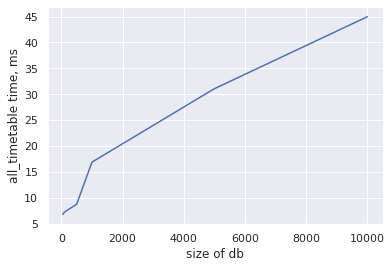

In [267]:
ax = sns.lineplot(x="size of db", y="all_timetable time, ms",data=ans)

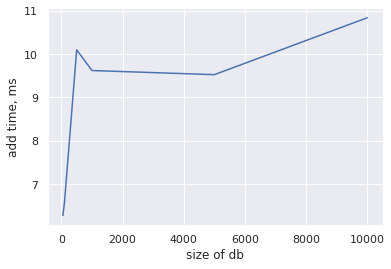

In [268]:
ax = sns.lineplot(x="size of db", y="add time, ms",data=ans)

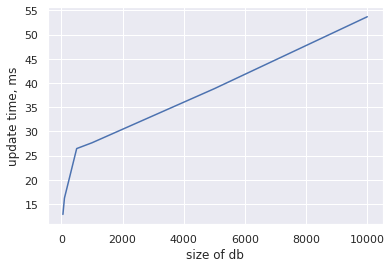

In [269]:
ax = sns.lineplot(x="size of db", y="update time, ms",data=ans)

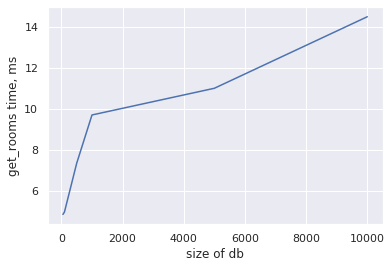

In [273]:
ax = sns.lineplot(x="size of db", y="get_rooms time, ms",data=ans)

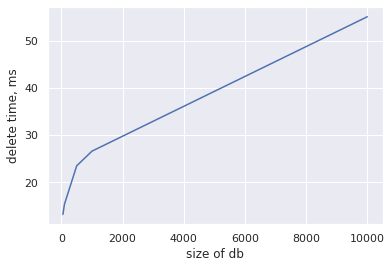

In [274]:
ax = sns.lineplot(x="size of db", y="delete time, ms",data=ans)

### Выводы по тестированию
Как можно заметить из представленных графиков среднее время обработки одного запроса неизбежно возрастает с увеличением размеров таблиц в базе данных. Однако, даже при максимальных нагрузках (в рамках тестирования это порядка 10000 записей в основной таблице), время обработки одного запроса не превышает 60 миллисекунд, что является приемлемым качеством для работы в реальных условиях. 

### Заключение
В рамках работы было проведено исследование применимости технологий реляционных баз данных для построения систем мониторинга свободных аудиторий и редактирования расписания в учебных заведениях. Была построена база данных, сгенерировано тестовой расписание, реализован интерфейс на языке Python 3.6 для работы с базой данных и реализации упомянутых в задаче возможностей, а также проведено тестирование производительности спроектированной системы. В дальнейшем планируется повышение оптимизации базы данных для уменьшения скорости запросов и построение более универсальной системы генерации расписаний.